# LT2316 H20 Assignment B - image autoencoder

## Introduction

In this assignment, you will define an image autoencoder model by changing/adding a limited amount of code to this notebook.  We will mark off what you will change.  

An autoencoder is a machine learning system/network that attempts to reconstruct the input (or a proxy for the input such as its context, as in neural language modeling) after compressing it to a smaller "bottleneck" representation. We can then extract the compressed representation for the input by running the input through the part of the trained model that ends in the compressing hidden layer.  For images, the input and output of the full model usually have the same shape, and the loss is the pixel-by-pixel colour channel error.  The embeddings of the images are extracted from some middle layer as a vector of much lower dimensionality.

We can then examine how "good" the embeddings are not only by the training loss but also by other techniques, such as clustering the embeddings. We will just test on the training data for simplicity (this is not always wrong if our goal is merely to get a generalized/compressed representation of a fixed amount of data).

Below we will mark off what you need to change and what you can change in markdown and code comments. The rest should remain untouched when you submit.  You are recommended to develop in a copy of the notebook you will submit and then port over your changes to the "final" notebook. That way, you can modify our code to test your code in your private notebook.

You will submit a saved notebook directly to Canvas.  

## Loading the data

In [1]:
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import random 
from PIL import Image
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
# You may add imports you feel you need for the notebook

In [2]:
%matplotlib inline

In [3]:
coco = COCO(annotation_file="/scratch/lt2316-h18-resources/coco/annotations/instances_train2017.json")

loading annotations into memory...
Done (t=18.73s)
creating index...
index created!


In [4]:
my_device = "cuda:3" # you can change the device to another GPU or the cpu for testing

In [5]:
def get_data(meta, datadir="/scratch/lt2316-h18-resources/coco/train2017"):
    return [(x['file_name'], Image.open("{}/{}".format(datadir, x['file_name'])).resize((100,100)).convert('RGB')) for x in meta]

def cat_img_load(category, coco, trainsize):
    catids = coco.getCatIds(catNms=category)
    imgids = coco.getImgIds(catIds=catids)
    
    random.shuffle(imgids)
    imgids = imgids[:trainsize]
    imgmeta = coco.loadImgs(ids=imgids)
    imgdata = get_data(imgmeta)
    
    imgdf = pd.DataFrame()
    imgnames = [x[0] for x in imgdata]
    imgarrays = [x[1] for x in imgdata]
    imgdf['imgs'] = imgarrays
    imgdf['filename'] = imgnames
    imgdf['class'] = category
    
    return imgdf

def get_tensors(*imgdfs):
    bigdf = pd.concat(imgdfs)
    print(len(bigdf))
    X = np.array([np.array(x) for x in bigdf['imgs']])
    print(X.shape)
    y = bigdf['class']
    filenames = bigdf['filename']
    X_scaled = StandardScaler().fit_transform(X.reshape(len(X),30000)).reshape(len(X), 100, 100, 3)
    X_tensor = torch.Tensor(X_scaled).to(my_device)
    return X_tensor, y, filenames

**We may change these MS COCO categories when testing as well as the number of retrieved items.**

In [6]:
airplanedf = cat_img_load("airplane", coco, 1000)
skateboarddf = cat_img_load("skateboard", coco, 1000)
mousedf = cat_img_load("mouse", coco, 1000)

In [7]:
len(airplanedf), len(skateboarddf), len(mousedf)

(1000, 1000, 1000)

In [8]:
X_tensor, y, filenames = get_tensors(airplanedf, skateboarddf, mousedf)

3000
(3000, 100, 100, 3)


## Batching and shuffling

**There should be no reason to edit this.**

In [9]:
class Batcher:
    def __init__(self, X, device, batch_size=50, max_iter=None):
        self.X = X
        self.device = device
        self.batch_size=batch_size
        self.max_iter = max_iter
        self.curr_iter = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.curr_iter == self.max_iter:
            raise StopIteration
        permutation = torch.randperm(self.X.size()[0], device=self.device)
        permX = self.X[permutation]
        splitX = torch.split(permX, self.batch_size)
        
        self.curr_iter += 1
        return splitX

## Autoencoder

**Here is where you will make the main changes.**

You will get **10 points** for making changes that run and produce representations that are *emb_size* in width when we extract the embeddings by calling *emb* on the training data and represent a good-faith attempt at building a simple autoencoder.  

We will give **1 to 3 points** for model design.

In [10]:
class ImageAutoencoder(nn.Module):
    # You may ADD hyperparameters here (and make requisite adaptations in the training loop below).
    # Document them under "Your analysis"
    def __init__(self, emb_size, height, width):
        super(ImageAutoencoder, self).__init__()
        self.emb_size = emb_size
        self.height = height
        self.width = width
        
        #input_size = height*width*3
        input_size = width*3
        
        # Define your network structure here using PyTorch.
        self.enc1 = nn.Linear(in_features=input_size, out_features=input_size//2)
        self.enc2 = nn.Linear(in_features=input_size//2, out_features=input_size//4)
        self.enc3 = nn.Linear(in_features=input_size//4, out_features=emb_size)
        self.dec1 = nn.Linear(in_features=emb_size, out_features=input_size//4)
        self.dec2 = nn.Linear(in_features=input_size//4, out_features=input_size//2)
        self.dec3 = nn.Linear(in_features=input_size//2, out_features=input_size)
        
        
    def forward(self, batch):
        # Apply the model to the batch here.  Watch out for the shapes!
        batch = batch.flatten(start_dim=2)
        
        en1 = self.enc1(batch)
        en1 = torch.relu(en1)
        en2 = self.enc2(en1)
        en2 = torch.relu(en2)
        en3 = self.enc3(en2)
        en3 = torch.relu(en3)
        de1 = self.dec1(en3)
        de1 = torch.relu(de1)
        de2 = self.dec2(de1)
        de2 = torch.relu(de2)
        de3 = self.dec3(de2)
        de3 = torch.relu(de3)
        
        out = de3.view(-1, self.height, self.width, 3)
    
        return out
        
    def emb(self, batch):
        # This should return the inner representation of the images, including for arbitrary unseen images
        # of the correct shape.
        batch = batch.flatten(start_dim=2)
        en1 = self.enc1(batch)
        en1 = torch.relu(en1)
        en2 = self.enc2(en1)
        en2 = torch.relu(en2)
        en3 = self.enc3(en2)
        en3 = torch.relu(en3)
        
        out = en3.view(-1, self.height, self.emb_size)
        return out

## Training

In [11]:
import torch.optim as optim

**You may make limited changes here.**

You can adapt *train()* slightly to handle any hyperparameters you added to *ImageAutoencoder*.  We may test by changing the values of the hyperparameters when we grade the assignment.

In [12]:
def train(X, batch_size, epochs, device, model=None):
    b = Batcher(X, device, batch_size=batch_size, max_iter=epochs)
    if not model:
         #We may change the embedding size by hand here. 
        m = ImageAutoencoder(400, X[0].size()[0], X[0].size()[1]).to(device)
    else:
        m = model
    loss = nn.MSELoss()
    optimizer = optim.Adam(m.parameters(), lr=0.005)
    epoch = 0
    for split in b:
        tot_loss = 0
        for batch in split:
            optimizer.zero_grad()
            o = m(batch)
            l = loss(o, batch)
            tot_loss += l
            l.backward()
            optimizer.step()
        print("Total loss in epoch {} is {}.".format(epoch, tot_loss))
        epoch += 1
    return m

## Running the model and checking the output

We're leaving the results of running our own simple model here just so you know what it might look like, but there's no guarantee or requirement that the performance of your model will be similar.  It's reasonably likely that it might even be better...whatever we mean by better. But it will very likely be different, especially as there is some randomness involved.

In [13]:
#toy_tensor = X_tensor[:2]
model = train(X_tensor, 5, 100, my_device) 
# You can add hyperparameters also here, change the number of epochs, batch size, etc.

Total loss in epoch 0 is 468.1220397949219.
Total loss in epoch 1 is 430.29913330078125.
Total loss in epoch 2 is 419.1936340332031.
Total loss in epoch 3 is 415.4427490234375.
Total loss in epoch 4 is 412.0444030761719.
Total loss in epoch 5 is 409.5655212402344.
Total loss in epoch 6 is 406.0353698730469.
Total loss in epoch 7 is 405.0388488769531.
Total loss in epoch 8 is 402.5996398925781.
Total loss in epoch 9 is 400.20123291015625.
Total loss in epoch 10 is 398.520751953125.
Total loss in epoch 11 is 399.448974609375.
Total loss in epoch 12 is 396.9067077636719.
Total loss in epoch 13 is 395.4009094238281.
Total loss in epoch 14 is 396.3202819824219.
Total loss in epoch 15 is 395.8784484863281.
Total loss in epoch 16 is 395.07684326171875.
Total loss in epoch 17 is 393.52044677734375.
Total loss in epoch 18 is 393.2605285644531.
Total loss in epoch 19 is 394.1667785644531.
Total loss in epoch 20 is 393.5994567871094.
Total loss in epoch 21 is 392.9233093261719.
Total loss in epoc

In [14]:
everything = model(X_tensor)

In [15]:
everything.shape
#X_tensor.shape

torch.Size([3000, 100, 100, 3])

In [16]:
sample = everything[1500].cpu().detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


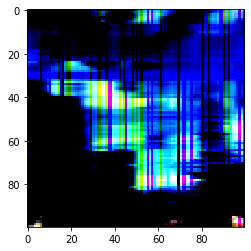

In [17]:
plt.imshow(sample)

In [18]:
sample_true = X_tensor[1500].cpu().detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


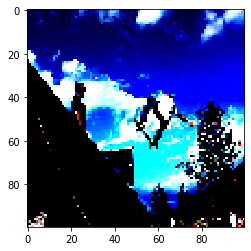

In [19]:
plt.imshow(sample_true)

In [34]:
embs = model.emb(X_tensor)

In [35]:
print(X_tensor.shape)
print(embs.shape)
embs=embs.flatten(start_dim=1)  # cheating here, figure out what to do with dimensions!!
print(embs.shape)

torch.Size([3000, 100, 100, 3])
torch.Size([3000, 100, 400])
torch.Size([3000, 40000])


In [36]:
embs = embs.cpu().detach().numpy()

In [37]:
kmeans = KMeans(3, random_state=700).fit(embs)

In [38]:
kmeans.labels_

array([2, 1, 2, ..., 2, 2, 0], dtype=int32)

In [39]:
truncated = TruncatedSVD(2).fit_transform(embs)

In [40]:
truncated.shape

(3000, 2)

In [41]:
plt.rcParams['figure.figsize'] = (12,12)

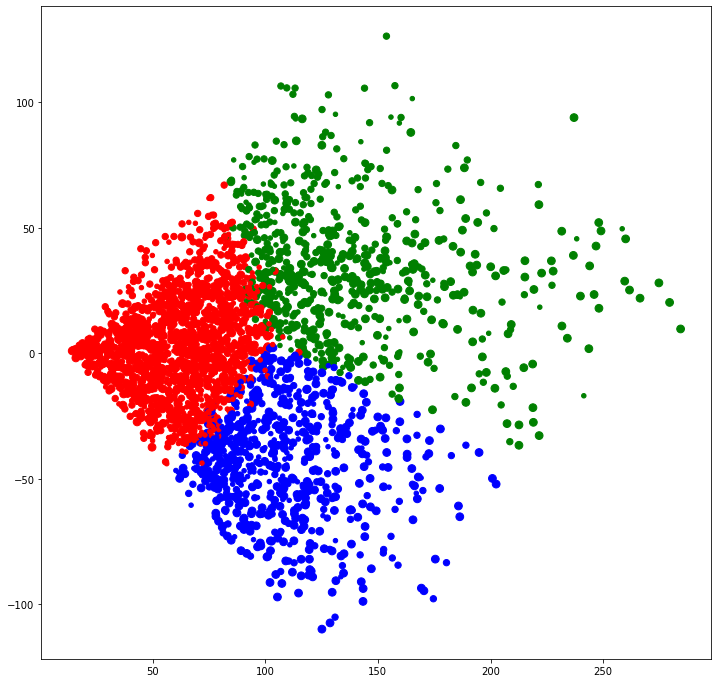

In [42]:
plt.scatter(truncated[:,0], truncated[:,1], c=[{0:'b',1:'g',2:'r'}[x] for x in kmeans.labels_], 
            s=[{"mouse":20, "skateboard":40, "airplane":60}[x] for x in y])

## Your analysis

**Informally analyze the performance of your model and clustering by examining cluster members to see the quality of the clusters and by experimenting with hyperparameters.  You can show your investigations here with markdown write-up.**

This will be graded on good-faith effort. **5 points** absolute for a reasonable effort (think 2-3 paragraphs of discussion and **3 points** used to identify effort quality.

## Your analysis (bonus)

**Search for an apply a method to analyze cluster purity relative to ground truth (4 bonus points), and apply it to hyperparameter and model variants (3 bonus points).**

## Scratch area for your convenience

We will ignore anything after this line.

In [ ]:
b = Batcher(X_tensor, device=my_device, batch_size=10, max_iter=3)
for split in b:
    for batch in split:
        print(batch.shape)
        print(batch)
        break
    break

In [44]:
# solve problem with CUDA and dimensions.. height*width*3 makes more sense!
# try to add different/other layers to the model, try different layer sizes..
# analysis part..